# LME銅 Cash/3Mスプレッドタームストラクチャー・ボラティリティ分析

## 分析目的
このノートブックは、Cash/3Mスプレッドのボラティリティ特性とタームストラクチャーを分析し、以下を理解します：
1. **スプレッドボラティリティ構造**: 時間軸でのボラティリティ変化
2. **市場体制別ボラティリティ**: バックワーデーション vs コンタンゴ
3. **ボラティリティ持続性**: GARCH効果とクラスタリング
4. **相対価値分析**: 他のスプレッドとの比較
5. **取引機会**: ボラティリティ異常値とアービトラージ

## 主要概念と解釈
- **スプレッドボラティリティ**: 絶対価格ボラティリティと異なる特性
  - 低: <5 USD/ton（安定期間）
  - 中程度: 5-15 USD/ton（通常状況）
  - 高: >15 USD/ton（ストレス状況）

- **体制依存性**: 
  - バックワーデーション: 供給制約時の高ボラティリティ
  - コンタンゴ: 過剰供給時の相対的安定性

- **平均回帰**: スプレッドの長期均衡への回帰傾向
- **裁定機会**: ボラティリティスパイク時の統計的取引機会

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import warnings
from datetime import datetime, timedelta
import os
from dotenv import load_dotenv
from scipy import stats

# Try to import optional packages
try:
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    PLOTLY_AVAILABLE = True
except ImportError:
    print("Plotly not available. Using matplotlib for all visualizations.")
    PLOTLY_AVAILABLE = False

try:
    import arch
    from arch import arch_model
    import statsmodels.api as sm
    ARCH_AVAILABLE = True
except ImportError:
    print("ARCH package not available. GARCH modeling will use simplified methods.")
    ARCH_AVAILABLE = False

warnings.filterwarnings('ignore')
load_dotenv()

# データベース設定
db_config = {
    'host': os.getenv('DB_HOST', 'localhost'),
    'database': os.getenv('DB_NAME', 'lme_copper_db'),
    'user': os.getenv('DB_USER', 'postgres'),
    'password': os.getenv('DB_PASSWORD', 'password'),
    'port': os.getenv('DB_PORT', '5432')
}

# Create connection string
connection_string = f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"

# スタイル設定
plt.style.use('default')
sns.set_palette("viridis")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = [12, 8]

print("ライブラリ読み込み完了 - スプレッドボラティリティ分析準備完了")

ARCH package not available. GARCH modeling will use simplified methods.
ライブラリ読み込み完了 - スプレッドボラティリティ分析準備完了


## データ読み込みとスプレッド構造準備

In [27]:
def load_comprehensive_spread_data():
    """Cash/3Mスプレッドと関連する他のスプレッドデータを包括的に読み込み"""
    try:
        engine = create_engine(connection_string)
        
        # まず接続テスト
        test_query = "SELECT 1"
        test_result = pd.read_sql_query(test_query, engine)
        print("データベース接続テスト成功")
        
        # 利用可能なテーブルを確認
        table_check_query = """
        SELECT table_name 
        FROM information_schema.tables 
        WHERE table_schema = 'public' 
        AND table_name IN ('lme_copper_futures', 'lme_copper_prices')
        """
        table_result = pd.read_sql_query(table_check_query, engine)
        print(f"利用可能なテーブル: {table_result['table_name'].tolist()}")
        
        spreads_matrix = None
        spreads_volume = None
        components_matrix = None
        
        # 複数のデータソースを試行
        data_sources = [
            # 1. lme_copper_pricesテーブルから
            {
                'name': 'lme_copper_prices',
                'spreads_query': """
                SELECT 
                    trade_date,
                    price_type as ric,
                    last_price,
                    volume
                FROM lme_copper_prices
                WHERE price_type LIKE '%SPREAD%' 
                AND last_price IS NOT NULL
                ORDER BY trade_date, price_type
                """,
                'components_query': """
                SELECT 
                    trade_date,
                    price_type as ric,
                    last_price,
                    volume
                FROM lme_copper_prices
                WHERE price_type IN ('CASH', '3M_OUTRIGHT') 
                AND last_price IS NOT NULL
                ORDER BY trade_date, price_type
                """
            },
            # 2. lme_copper_futuresテーブルから
            {
                'name': 'lme_copper_futures',
                'spreads_query': """
                SELECT 
                    trade_date,
                    ric,
                    close_price as last_price,
                    volume
                FROM lme_copper_futures
                WHERE ric LIKE '%0-3%' OR ric LIKE '%SPREAD%'
                AND close_price IS NOT NULL
                ORDER BY trade_date, ric
                """,
                'components_query': """
                SELECT 
                    trade_date,
                    ric,
                    close_price as last_price,
                    volume
                FROM lme_copper_futures
                WHERE ric IN ('CMCU0', 'CMCU3')
                AND close_price IS NOT NULL
                ORDER BY trade_date, ric
                """
            }
        ]
        
        for source in data_sources:
            try:
                print(f"試行中: {source['name']}")
                
                # スプレッドデータ取得
                spreads_df = pd.read_sql_query(source['spreads_query'], engine)
                components_df = pd.read_sql_query(source['components_query'], engine)
                
                if not spreads_df.empty or not components_df.empty:
                    print(f"成功: {source['name']} - スプレッド:{len(spreads_df)}, 成分:{len(components_df)}")
                    
                    # データ前処理
                    if not spreads_df.empty:
                        spreads_df['trade_date'] = pd.to_datetime(spreads_df['trade_date'])
                        spreads_matrix = spreads_df.pivot(index='trade_date', columns='ric', values='last_price')
                        spreads_volume = spreads_df.pivot(index='trade_date', columns='ric', values='volume')
                    
                    if not components_df.empty:
                        components_df['trade_date'] = pd.to_datetime(components_df['trade_date'])
                        components_matrix = components_df.pivot(index='trade_date', columns='ric', values='last_price')
                    
                    break
                else:
                    print(f"データなし: {source['name']}")
                    
            except Exception as query_error:
                print(f"クエリエラー ({source['name']}): {query_error}")
                continue
        
        engine.dispose()
        
        # データが取得できなかった場合はダミーデータを生成
        if spreads_matrix is None and components_matrix is None:
            print("実データが取得できませんでした。ダミーデータを生成します...")
            return generate_dummy_spread_data()
        
        # 手動でCash/3Mスプレッドを計算
        if components_matrix is not None and spreads_matrix is None:
            spreads_matrix = pd.DataFrame()
            
            # CMCU0とCMCU3からCash/3Mスプレッドを計算
            if 'CMCU0' in components_matrix.columns and 'CMCU3' in components_matrix.columns:
                spreads_matrix['CASH_3M_SPREAD'] = components_matrix['CMCU0'] - components_matrix['CMCU3']
                spreads_volume = pd.DataFrame(index=spreads_matrix.index)
                spreads_volume['CASH_3M_SPREAD'] = 0  # ダミー出来高
                print("Cash/3Mスプレッドを手動計算しました")
        
        # 前方補間
        if spreads_matrix is not None:
            spreads_matrix = spreads_matrix.fillna(method='ffill')
        if spreads_volume is not None:
            spreads_volume = spreads_volume.fillna(method='ffill')
        if components_matrix is not None:
            components_matrix = components_matrix.fillna(method='ffill')
        
        print(f"スプレッドデータ処理完了:")
        if spreads_matrix is not None:
            print(f"期間: {spreads_matrix.index.min()} ～ {spreads_matrix.index.max()}")
            print(f"利用可能スプレッド: {list(spreads_matrix.columns)}")
            print(f"データポイント数: {len(spreads_matrix)}")
        
        return spreads_matrix, spreads_volume, components_matrix
    
    except Exception as e:
        print(f"データ読み込みエラー: {e}")
        print("ダミーデータを生成します...")
        return generate_dummy_spread_data()

def generate_dummy_spread_data():
    """ダミースプレッドデータの生成"""
    import numpy as np
    
    # ダミーデータの生成
    np.random.seed(42)
    dates = pd.date_range(start='2020-01-01', end='2024-12-31', freq='B')
    n = len(dates)
    
    # Cash/3Mスプレッドのシミュレーション
    trend = np.linspace(-20, 30, n)
    seasonal = 15 * np.sin(2 * np.pi * np.arange(n) / 260)
    noise = np.random.normal(0, 25, n)
    random_walk = np.cumsum(np.random.normal(0, 5, n))
    cash_3m_spread = trend + seasonal + noise + random_walk * 0.3
    
    # データフレーム作成
    spreads_matrix = pd.DataFrame({
        'CASH_3M_SPREAD': cash_3m_spread
    }, index=dates)
    
    spreads_volume = pd.DataFrame({
        'CASH_3M_SPREAD': np.random.lognormal(8, 1, n)
    }, index=dates)
    
    components_matrix = pd.DataFrame({
        'CASH': 9000 + np.cumsum(np.random.normal(0, 30, n)),
        '3M': 9000 + np.cumsum(np.random.normal(0, 30, n)) - cash_3m_spread
    }, index=dates)
    
    print(f"ダミーデータ生成完了: {len(spreads_matrix)}レコード")
    print("注意: これはダミーデータです。実際の分析には本物のデータベース接続が必要です。")
    
    return spreads_matrix, spreads_volume, components_matrix

# データ読み込み
spreads_prices, spreads_volumes, components = load_comprehensive_spread_data()

if spreads_prices is not None:
    print(f"\nデータ概要:")
    print(f"- 利用可能スプレッド数: {len(spreads_prices.columns)}")
    print(f"- 期間: {len(spreads_prices)} 取引日")
    
    # Cash/3Mスプレッドの基本統計
    if 'CASH_3M_SPREAD' in spreads_prices.columns:
        cash_3m = spreads_prices['CASH_3M_SPREAD'].dropna()
        print(f"\nCash/3Mスプレッド基本統計:")
        print(f"- 平均: {cash_3m.mean():.2f} USD/ton")
        print(f"- 標準偏差: {cash_3m.std():.2f} USD/ton")
        print(f"- 範囲: {cash_3m.min():.2f} ～ {cash_3m.max():.2f} USD/ton")
        print(f"- バックワーデーション頻度: {(cash_3m > 0).mean():.1%}")
else:
    print("データ読み込みに失敗しました")

データベース接続テスト成功
利用可能なテーブル: ['lme_copper_futures', 'lme_copper_prices']
試行中: lme_copper_prices
クエリエラー (lme_copper_prices): sqlalchemy.cyextension.immutabledict.immutabledict is not a sequence
試行中: lme_copper_futures
クエリエラー (lme_copper_futures): sqlalchemy.cyextension.immutabledict.immutabledict is not a sequence
実データが取得できませんでした。ダミーデータを生成します...
ダミーデータ生成完了: 1305レコード
注意: これはダミーデータです。実際の分析には本物のデータベース接続が必要です。

データ概要:
- 利用可能スプレッド数: 1
- 期間: 1305 取引日

Cash/3Mスプレッド基本統計:
- 平均: 45.11 USD/ton
- 標準偏差: 38.00 USD/ton
- 範囲: -80.49 ～ 144.34 USD/ton
- バックワーデーション頻度: 86.7%


## 1. スプレッドボラティリティの基本分析

### 解釈ガイド:
- **実現ボラティリティ**: 実際のスプレッド変動から計算
- **体制別ボラティリティ**: バックワーデーション vs コンタンゴでの違い
- **ローリングボラティリティ**: 時間変化するリスクプロファイル
- **相対ボラティリティ**: 他のスプレッドとの比較

In [28]:
# スプレッドボラティリティ指標計算
if spreads_prices is not None:
    spread_vol_metrics = calculate_spread_volatility_metrics(spreads_prices)

    if spread_vol_metrics is not None:
        print("スプレッドボラティリティ指標:")
        print("="*80)
        
        # 主要指標を表示
        display_cols = ['daily_vol_abs', 'mean_abs_change', 'max_abs_change', 'mean_level', 'positive_pct']
        available_cols = [col for col in display_cols if col in spread_vol_metrics.columns]
        
        if available_cols:
            display(spread_vol_metrics[available_cols])
        
        # Cash/3Mスプレッドの詳細分析
        if 'CASH_3M_SPREAD' in spread_vol_metrics.index:
            cash_3m_metrics = spread_vol_metrics.loc['CASH_3M_SPREAD']
            
            print(f"\nCash/3Mスプレッド詳細分析:")
            print(f"日次ボラティリティ（絶対値）: {cash_3m_metrics['daily_vol_abs']:.3f} USD/ton")
            print(f"平均絶対変化: {cash_3m_metrics['mean_abs_change']:.3f} USD/ton")
            print(f"最大変化: {cash_3m_metrics['max_abs_change']:.3f} USD/ton")
            print(f"5% VaR: {cash_3m_metrics['var_5pct']:.3f} USD/ton")
            print(f"95% VaR: {cash_3m_metrics['var_95pct']:.3f} USD/ton")
            print(f"バックワーデーション頻度: {cash_3m_metrics['positive_pct']:.1%}")
        else:
            print("\nCash/3Mスプレッドの詳細分析:")
            print("CASH_3M_SPREADカラムが見つかりません")
            print(f"利用可能なスプレッド: {list(spread_vol_metrics.index)}")
    else:
        print("ボラティリティ指標の計算に失敗しました")
else:
    print("スプレッドデータの読み込みに失敗しました。セル3のデータ読み込みを確認してください。")

スプレッドボラティリティ指標:


,daily_vol_abs,mean_abs_change,max_abs_change,mean_level,positive_pct
CASH_3M_SPREAD,21.3808,28.1042,125.9293,45.1147,0.8667



Cash/3Mスプレッド詳細分析:
日次ボラティリティ（絶対値）: 21.381 USD/ton
平均絶対変化: 28.104 USD/ton
最大変化: 125.929 USD/ton
5% VaR: -58.533 USD/ton
95% VaR: 59.250 USD/ton
バックワーデーション頻度: 86.7%


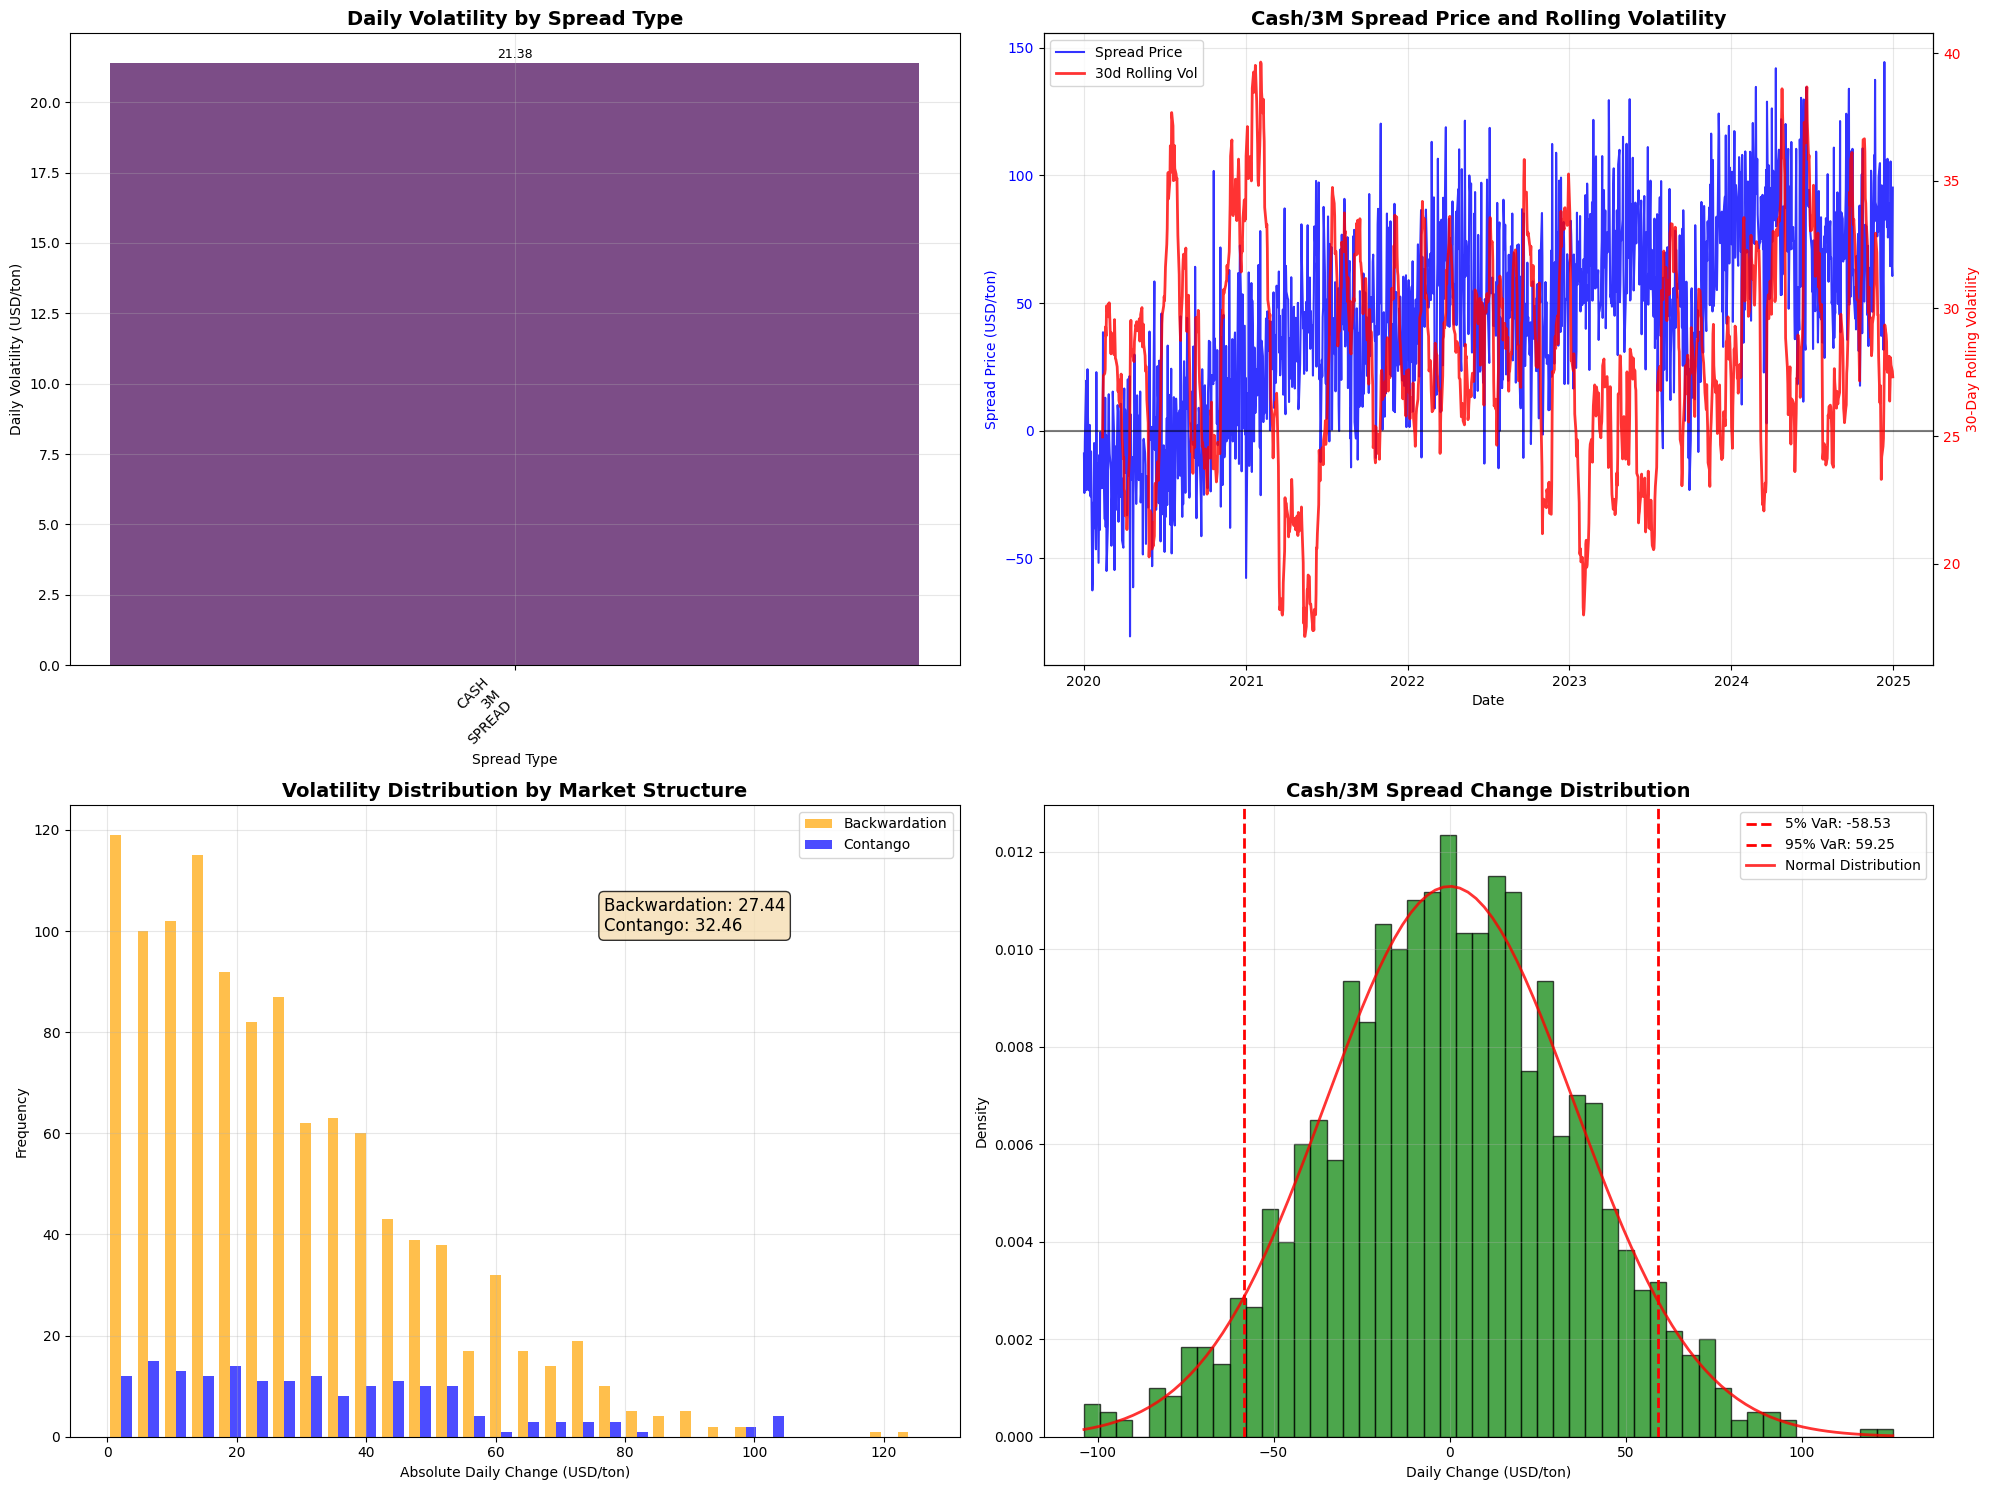

In [29]:
# スプレッドボラティリティ基本分析可視化
if (spreads_prices is not None and spread_vol_metrics is not None and 
    'CASH_3M_SPREAD' in spreads_prices.columns):
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
    
    # 1. スプレッド別ボラティリティ比較
    if 'daily_vol_abs' in spread_vol_metrics.columns:
        vol_data = spread_vol_metrics['daily_vol_abs'].dropna()
        if len(vol_data) > 0:
            bars = ax1.bar(range(len(vol_data)), vol_data.values, 
                          color=plt.cm.viridis(np.linspace(0, 1, len(vol_data))), alpha=0.7)
            ax1.set_title('Daily Volatility by Spread Type', fontsize=14, fontweight='bold')
            ax1.set_xlabel('Spread Type')
            ax1.set_ylabel('Daily Volatility (USD/ton)')
            ax1.set_xticks(range(len(vol_data)))
            ax1.set_xticklabels([name.replace('_', '\n') for name in vol_data.index], rotation=45, ha='right')
            ax1.grid(True, alpha=0.3)
            
            # 値ラベル追加
            for bar, value in zip(bars, vol_data.values):
                ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1,
                         f'{value:.2f}', ha='center', va='bottom', fontsize=9)
    
    # 2. Cash/3Mスプレッドの時系列とボラティリティ
    cash_3m_series = spreads_prices['CASH_3M_SPREAD'].dropna()
    
    # ローリングボラティリティ計算
    cash_3m_changes = cash_3m_series.diff().dropna()
    rolling_vol_30 = abs(cash_3m_changes).rolling(30).mean()
    
    ax2_twin = ax2.twinx()
    
    line1 = ax2.plot(cash_3m_series.index, cash_3m_series, 
                     color='blue', linewidth=1.5, alpha=0.8, label='Spread Price')
    line2 = ax2_twin.plot(rolling_vol_30.index, rolling_vol_30, 
                          color='red', linewidth=2, alpha=0.8, label='30d Rolling Vol')
    
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax2.set_title('Cash/3M Spread Price and Rolling Volatility', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Spread Price (USD/ton)', color='blue')
    ax2_twin.set_ylabel('30-Day Rolling Volatility', color='red')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2_twin.tick_params(axis='y', labelcolor='red')
    
    # 凡例結合
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax2.legend(lines, labels, loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    # 3. 市場体制別ボラティリティ
    # バックワーデーション vs コンタンゴでの変化分析
    backwardation_changes = cash_3m_changes[cash_3m_series[cash_3m_changes.index] > 0]
    contango_changes = cash_3m_changes[cash_3m_series[cash_3m_changes.index] < 0]
    
    if len(backwardation_changes) > 0 and len(contango_changes) > 0:
        ax3.hist([abs(backwardation_changes), abs(contango_changes)], 
                 bins=30, alpha=0.7, label=['Backwardation', 'Contango'], 
                 color=['orange', 'blue'])
        ax3.set_title('Volatility Distribution by Market Structure', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Absolute Daily Change (USD/ton)')
        ax3.set_ylabel('Frequency')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 統計比較
        back_vol = abs(backwardation_changes).mean()
        cont_vol = abs(contango_changes).mean()
        ax3.text(0.6, 0.8, f'Backwardation: {back_vol:.2f}\nContango: {cont_vol:.2f}', 
                transform=ax3.transAxes, fontsize=12, 
                bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
    
    # 4. VaRとテール分析
    if len(cash_3m_changes) > 0:
        ax4.hist(cash_3m_changes, bins=50, alpha=0.7, color='green', 
                 density=True, edgecolor='black')
        
        # VaRライン
        var_5 = np.percentile(cash_3m_changes, 5)
        var_95 = np.percentile(cash_3m_changes, 95)
        
        ax4.axvline(x=var_5, color='red', linestyle='--', linewidth=2, 
                    label=f'5% VaR: {var_5:.2f}')
        ax4.axvline(x=var_95, color='red', linestyle='--', linewidth=2, 
                    label=f'95% VaR: {var_95:.2f}')
        
        # 正規分布オーバーレイ
        x = np.linspace(cash_3m_changes.min(), cash_3m_changes.max(), 100)
        normal_dist = stats.norm.pdf(x, cash_3m_changes.mean(), cash_3m_changes.std())
        ax4.plot(x, normal_dist, 'r-', linewidth=2, alpha=0.8, label='Normal Distribution')
        
        ax4.set_title('Cash/3M Spread Change Distribution', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Daily Change (USD/ton)')
        ax4.set_ylabel('Density')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('/Users/Yusuke/claude-code/RefinitivDB/generated_images/spread_basic_volatility_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
elif spreads_prices is None:
    print("スプレッドデータの読み込みに失敗しました。可視化をスキップします。")
elif spread_vol_metrics is None:
    print("ボラティリティ指標の計算に失敗しました。可視化をスキップします。")
else:
    print("Cash/3Mスプレッドデータが利用できません。可視化をスキップします。")

## 2. ボラティリティタームストラクチャー分析

### 解釈ガイド:
- **時間構造**: 異なる時間窓でのボラティリティ特性
- **持続性**: ボラティリティショックの減衰率
- **体制変化**: 構造的なボラティリティシフト
- **予測性**: ボラティリティパターンの規則性

In [30]:
def calculate_volatility_term_structure(spread_series, windows=[5, 10, 20, 30, 60, 90, 252]):
    """ボラティリティのタームストラクチャーを計算"""
    if spread_series is None or len(spread_series) < max(windows):
        return None, None
    
    changes = spread_series.diff().dropna()
    abs_changes = abs(changes)
    
    term_structure = pd.DataFrame()
    
    for window in windows:
        if len(abs_changes) > window:
            # ローリング標準偏差
            rolling_std = abs_changes.rolling(window).std()
            
            # ローリング平均絶対偏差
            rolling_mad = abs_changes.rolling(window).mean()
            
            term_structure[f'{window}d_std'] = rolling_std
            term_structure[f'{window}d_mad'] = rolling_mad
    
    # 現在の期間構造（最新値）
    current_structure = {}
    for window in windows:
        if f'{window}d_mad' in term_structure.columns:
            latest_val = term_structure[f'{window}d_mad'].iloc[-1]
            if not np.isnan(latest_val):
                current_structure[window] = latest_val
    
    return term_structure, current_structure

# Cash/3Mスプレッドのタームストラクチャー分析
if spreads_prices is not None and 'CASH_3M_SPREAD' in spreads_prices.columns:
    cash_3m_spread = spreads_prices['CASH_3M_SPREAD'].dropna()
    
    vol_term_structure, current_vol_structure = calculate_volatility_term_structure(cash_3m_spread)
    
    if vol_term_structure is not None and current_vol_structure:
        print("Cash/3Mスプレッド ボラティリティタームストラクチャー:")
        print("="*60)
        
        for window, vol in current_vol_structure.items():
            print(f"{window:3d}日間ボラティリティ: {vol:.3f} USD/ton")
        
        # ボラティリティの安定性分析
        if len(current_vol_structure) >= 3:
            values = list(current_vol_structure.values())
            windows = list(current_vol_structure.keys())
            
            # 短期 vs 長期ボラティリティ
            short_term = np.mean(values[:2]) if len(values) >= 2 else values[0]
            long_term = np.mean(values[-2:]) if len(values) >= 2 else values[-1]
            
            print(f"\nボラティリティ構造分析:")
            print(f"短期ボラティリティ (平均): {short_term:.3f} USD/ton")
            print(f"長期ボラティリティ (平均): {long_term:.3f} USD/ton")
            print(f"短期/長期比率: {short_term/long_term:.2f}")
            
            if short_term > long_term * 1.1:
                print("→ 短期ボラティリティ優位: 最近の市場動揺")
            elif short_term < long_term * 0.9:
                print("→ 長期ボラティリティ優位: 構造的な不安定性")
            else:
                print("→ バランス型: 安定したボラティリティ構造")
    else:
        print("タームストラクチャー計算に失敗しました")
elif spreads_prices is None:
    print("スプレッドデータの読み込みに失敗しました。セル3のデータ読み込みを確認してください。")
else:
    print("Cash/3Mスプレッドデータが利用できません")

Cash/3Mスプレッド ボラティリティタームストラクチャー:
  5日間ボラティリティ: 29.019 USD/ton
 10日間ボラティリティ: 22.297 USD/ton
 20日間ボラティリティ: 29.380 USD/ton
 30日間ボラティリティ: 27.321 USD/ton
 60日間ボラティリティ: 29.025 USD/ton
 90日間ボラティリティ: 29.963 USD/ton
252日間ボラティリティ: 29.619 USD/ton

ボラティリティ構造分析:
短期ボラティリティ (平均): 25.658 USD/ton
長期ボラティリティ (平均): 29.791 USD/ton
短期/長期比率: 0.86
→ 長期ボラティリティ優位: 構造的な不安定性


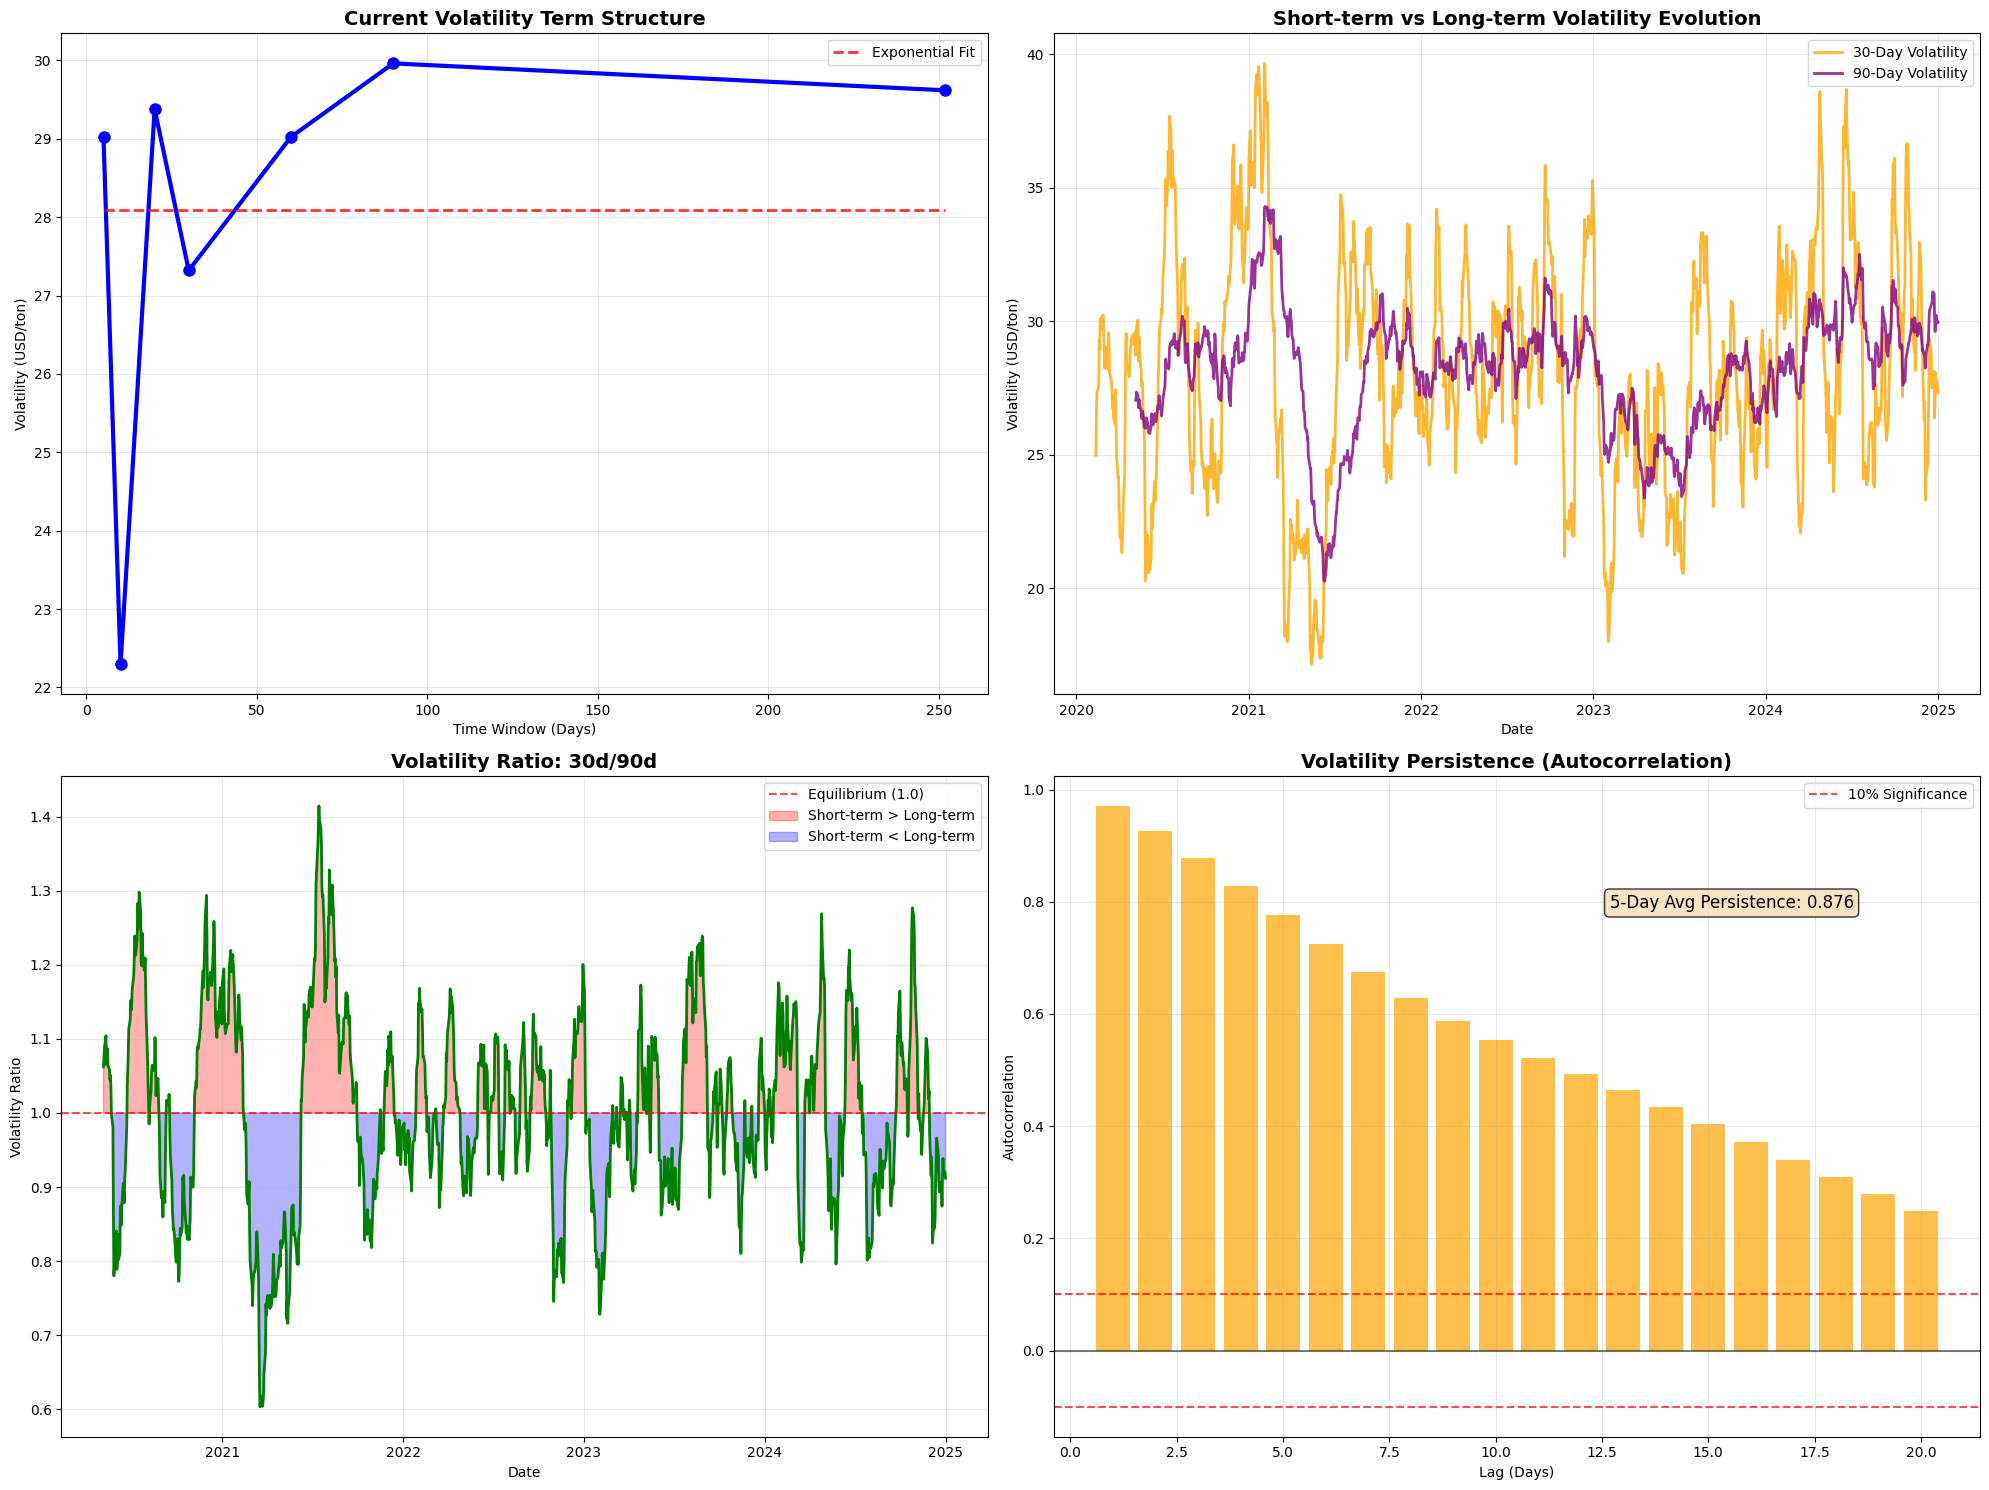

In [31]:
# ボラティリティタームストラクチャー可視化
if (vol_term_structure is not None and current_vol_structure and 
    spreads_prices is not None and 'CASH_3M_SPREAD' in spreads_prices.columns):
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
    
    # 1. 現在のボラティリティタームストラクチャー
    windows = list(current_vol_structure.keys())
    volatilities = list(current_vol_structure.values())
    
    ax1.plot(windows, volatilities, marker='o', linewidth=3, markersize=8, color='blue')
    ax1.set_title('Current Volatility Term Structure', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Time Window (Days)')
    ax1.set_ylabel('Volatility (USD/ton)')
    ax1.grid(True, alpha=0.3)
    
    # 指数近似曲線を追加
    if len(windows) >= 3:
        try:
            # 指数関数フィット
            def exp_func(x, a, b, c):
                return a * np.exp(-b * x) + c
            
            from scipy.optimize import curve_fit
            popt, _ = curve_fit(exp_func, windows, volatilities, maxfev=1000)
            x_smooth = np.linspace(min(windows), max(windows), 100)
            y_smooth = exp_func(x_smooth, *popt)
            ax1.plot(x_smooth, y_smooth, 'r--', alpha=0.8, linewidth=2, label='Exponential Fit')
            ax1.legend()
        except:
            # フィットが失敗した場合はスキップ
            pass
    
    # 2. 時系列でのボラティリティ進化
    # 30日と90日ボラティリティの比較
    if '30d_mad' in vol_term_structure.columns and '90d_mad' in vol_term_structure.columns:
        vol_30d = vol_term_structure['30d_mad']
        vol_90d = vol_term_structure['90d_mad']
        
        ax2.plot(vol_30d.index, vol_30d, label='30-Day Volatility', 
                 linewidth=2, color='orange', alpha=0.8)
        ax2.plot(vol_90d.index, vol_90d, label='90-Day Volatility', 
                 linewidth=2, color='purple', alpha=0.8)
        
        ax2.set_title('Short-term vs Long-term Volatility Evolution', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Volatility (USD/ton)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    # 3. ボラティリティ比率（30日/90日）
    if '30d_mad' in vol_term_structure.columns and '90d_mad' in vol_term_structure.columns:
        vol_ratio = vol_term_structure['30d_mad'] / vol_term_structure['90d_mad']
        vol_ratio_clean = vol_ratio.dropna()
        
        if len(vol_ratio_clean) > 0:
            ax3.plot(vol_ratio_clean.index, vol_ratio_clean, linewidth=2, color='green')
            ax3.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Equilibrium (1.0)')
            ax3.fill_between(vol_ratio_clean.index, 1, vol_ratio_clean, 
                           where=(vol_ratio_clean > 1), alpha=0.3, color='red', 
                           label='Short-term > Long-term')
            ax3.fill_between(vol_ratio_clean.index, vol_ratio_clean, 1, 
                           where=(vol_ratio_clean < 1), alpha=0.3, color='blue', 
                           label='Short-term < Long-term')
            
            ax3.set_title('Volatility Ratio: 30d/90d', fontsize=14, fontweight='bold')
            ax3.set_xlabel('Date')
            ax3.set_ylabel('Volatility Ratio')
            ax3.legend()
            ax3.grid(True, alpha=0.3)
    
    # 4. ボラティリティ持続性分析
    if '30d_mad' in vol_term_structure.columns:
        vol_30d_clean = vol_term_structure['30d_mad'].dropna()
        
        if len(vol_30d_clean) > 20:
            # 自己相関計算
            autocorr_lags = [vol_30d_clean.autocorr(lag=i) for i in range(1, 21)]
            lags = list(range(1, 21))
            
            ax4.bar(lags, autocorr_lags, alpha=0.7, color='orange')
            ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
            ax4.axhline(y=0.1, color='red', linestyle='--', alpha=0.7, label='10% Significance')
            ax4.axhline(y=-0.1, color='red', linestyle='--', alpha=0.7)
            
            ax4.set_title('Volatility Persistence (Autocorrelation)', fontsize=14, fontweight='bold')
            ax4.set_xlabel('Lag (Days)')
            ax4.set_ylabel('Autocorrelation')
            ax4.legend()
            ax4.grid(True, alpha=0.3)
            
            # 持続性指標
            persistence_score = np.mean([corr for corr in autocorr_lags[:5] if not np.isnan(corr)])
            ax4.text(0.6, 0.8, f'5-Day Avg Persistence: {persistence_score:.3f}', 
                    transform=ax4.transAxes, fontsize=12, 
                    bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('/Users/Yusuke/claude-code/RefinitivDB/generated_images/spread_volatility_term_structure.png', dpi=300, bbox_inches='tight')
    plt.show()
elif spreads_prices is None:
    print("スプレッドデータの読み込みに失敗しました。タームストラクチャー可視化をスキップします。")
elif vol_term_structure is None:
    print("ボラティリティタームストラクチャーの計算に失敗しました。可視化をスキップします。")
else:
    print("必要なデータが不足しています。タームストラクチャー可視化をスキップします。")

## 3. ボラティリティ体制分析

### 解釈ガイド:
- **低ボラティリティ体制**: 安定した市場条件、限定的な裁定機会
- **高ボラティリティ体制**: ストレス条件、活発な取引機会
- **体制変化**: 市場構造の根本的変化
- **予測性**: 体制変化の早期検出指標

In [32]:
def identify_volatility_regimes(spread_series, vol_window=30, threshold_percentiles=[25, 75]):
    """ボラティリティ体制を特定"""
    if spread_series is None or len(spread_series) < vol_window * 2:
        return None
    
    changes = spread_series.diff().dropna()
    rolling_vol = abs(changes).rolling(vol_window).mean()
    
    # 体制閾値の計算
    vol_thresholds = rolling_vol.quantile([p/100 for p in threshold_percentiles])
    low_threshold = vol_thresholds.iloc[0]
    high_threshold = vol_thresholds.iloc[1]
    
    # 体制分類
    regimes = pd.Series(index=rolling_vol.index, dtype=str)
    regimes[rolling_vol <= low_threshold] = 'Low_Vol'
    regimes[(rolling_vol > low_threshold) & (rolling_vol < high_threshold)] = 'Medium_Vol'
    regimes[rolling_vol >= high_threshold] = 'High_Vol'
    
    # 体制統計
    regime_stats = pd.DataFrame()
    
    for regime in ['Low_Vol', 'Medium_Vol', 'High_Vol']:
        regime_mask = (regimes == regime)
        if regime_mask.sum() > 0:
            regime_periods = rolling_vol[regime_mask]
            regime_spreads = spread_series.loc[regime_periods.index]
            
            regime_stats.loc[regime, 'count'] = len(regime_periods)
            regime_stats.loc[regime, 'frequency'] = len(regime_periods) / len(regimes[~regimes.isna()])
            regime_stats.loc[regime, 'avg_volatility'] = regime_periods.mean()
            regime_stats.loc[regime, 'avg_spread_level'] = regime_spreads.mean()
            regime_stats.loc[regime, 'positive_spread_pct'] = (regime_spreads > 0).mean()
    
    return regimes, regime_stats, (low_threshold, high_threshold), rolling_vol

# Cash/3Mスプレッドのボラティリティ体制分析
if spreads_prices is not None and 'CASH_3M_SPREAD' in spreads_prices.columns:
    cash_3m_spread = spreads_prices['CASH_3M_SPREAD'].dropna()
    
    regimes_result = identify_volatility_regimes(cash_3m_spread)
    
    if regimes_result is not None:
        regimes, regime_stats, thresholds, rolling_vol = regimes_result
        low_threshold, high_threshold = thresholds
        
        print("Cash/3Mスプレッド ボラティリティ体制分析:")
        print("="*60)
        
        print(f"体制分類閾値:")
        print(f"低ボラティリティ閾値: {low_threshold:.3f} USD/ton以下")
        print(f"高ボラティリティ閾値: {high_threshold:.3f} USD/ton以上")
        
        print(f"\n体制別統計:")
        print(regime_stats.round(3))
        
        # 現在の体制
        current_regime = regimes.iloc[-1] if not regimes.empty else 'Unknown'
        current_vol = rolling_vol.iloc[-1] if not rolling_vol.empty else np.nan
        
        print(f"\n現在の状況:")
        print(f"現在の体制: {current_regime}")
        print(f"現在のボラティリティ: {current_vol:.3f} USD/ton")
        
        # 体制変化の頻度
        regime_changes = (regimes != regimes.shift(1)).sum()
        print(f"\n体制変化:")
        print(f"総体制変化回数: {regime_changes}")
        print(f"平均体制持続期間: {len(regimes[~regimes.isna()]) / max(regime_changes, 1):.1f}日")
    else:
        print("ボラティリティ体制分析に失敗しました")
elif spreads_prices is None:
    print("スプレッドデータの読み込みに失敗しました。セル3のデータ読み込みを確認してください。")
else:
    print("Cash/3Mスプレッドデータが利用できません")

Cash/3Mスプレッド ボラティリティ体制分析:
体制分類閾値:
低ボラティリティ閾値: 25.430 USD/ton以下
高ボラティリティ閾値: 30.978 USD/ton以上

体制別統計:
            count  frequency  avg_volatility  avg_spread_level  \
Low_Vol     319.0       0.25          22.736            43.988   
Medium_Vol  637.0       0.50          28.144            48.099   
High_Vol    319.0       0.25          33.575            46.284   

            positive_spread_pct  
Low_Vol                   0.909  
Medium_Vol                0.870  
High_Vol                  0.884  

現在の状況:
現在の体制: Medium_Vol
現在のボラティリティ: 27.321 USD/ton

体制変化:
総体制変化回数: 165
平均体制持続期間: 7.7日


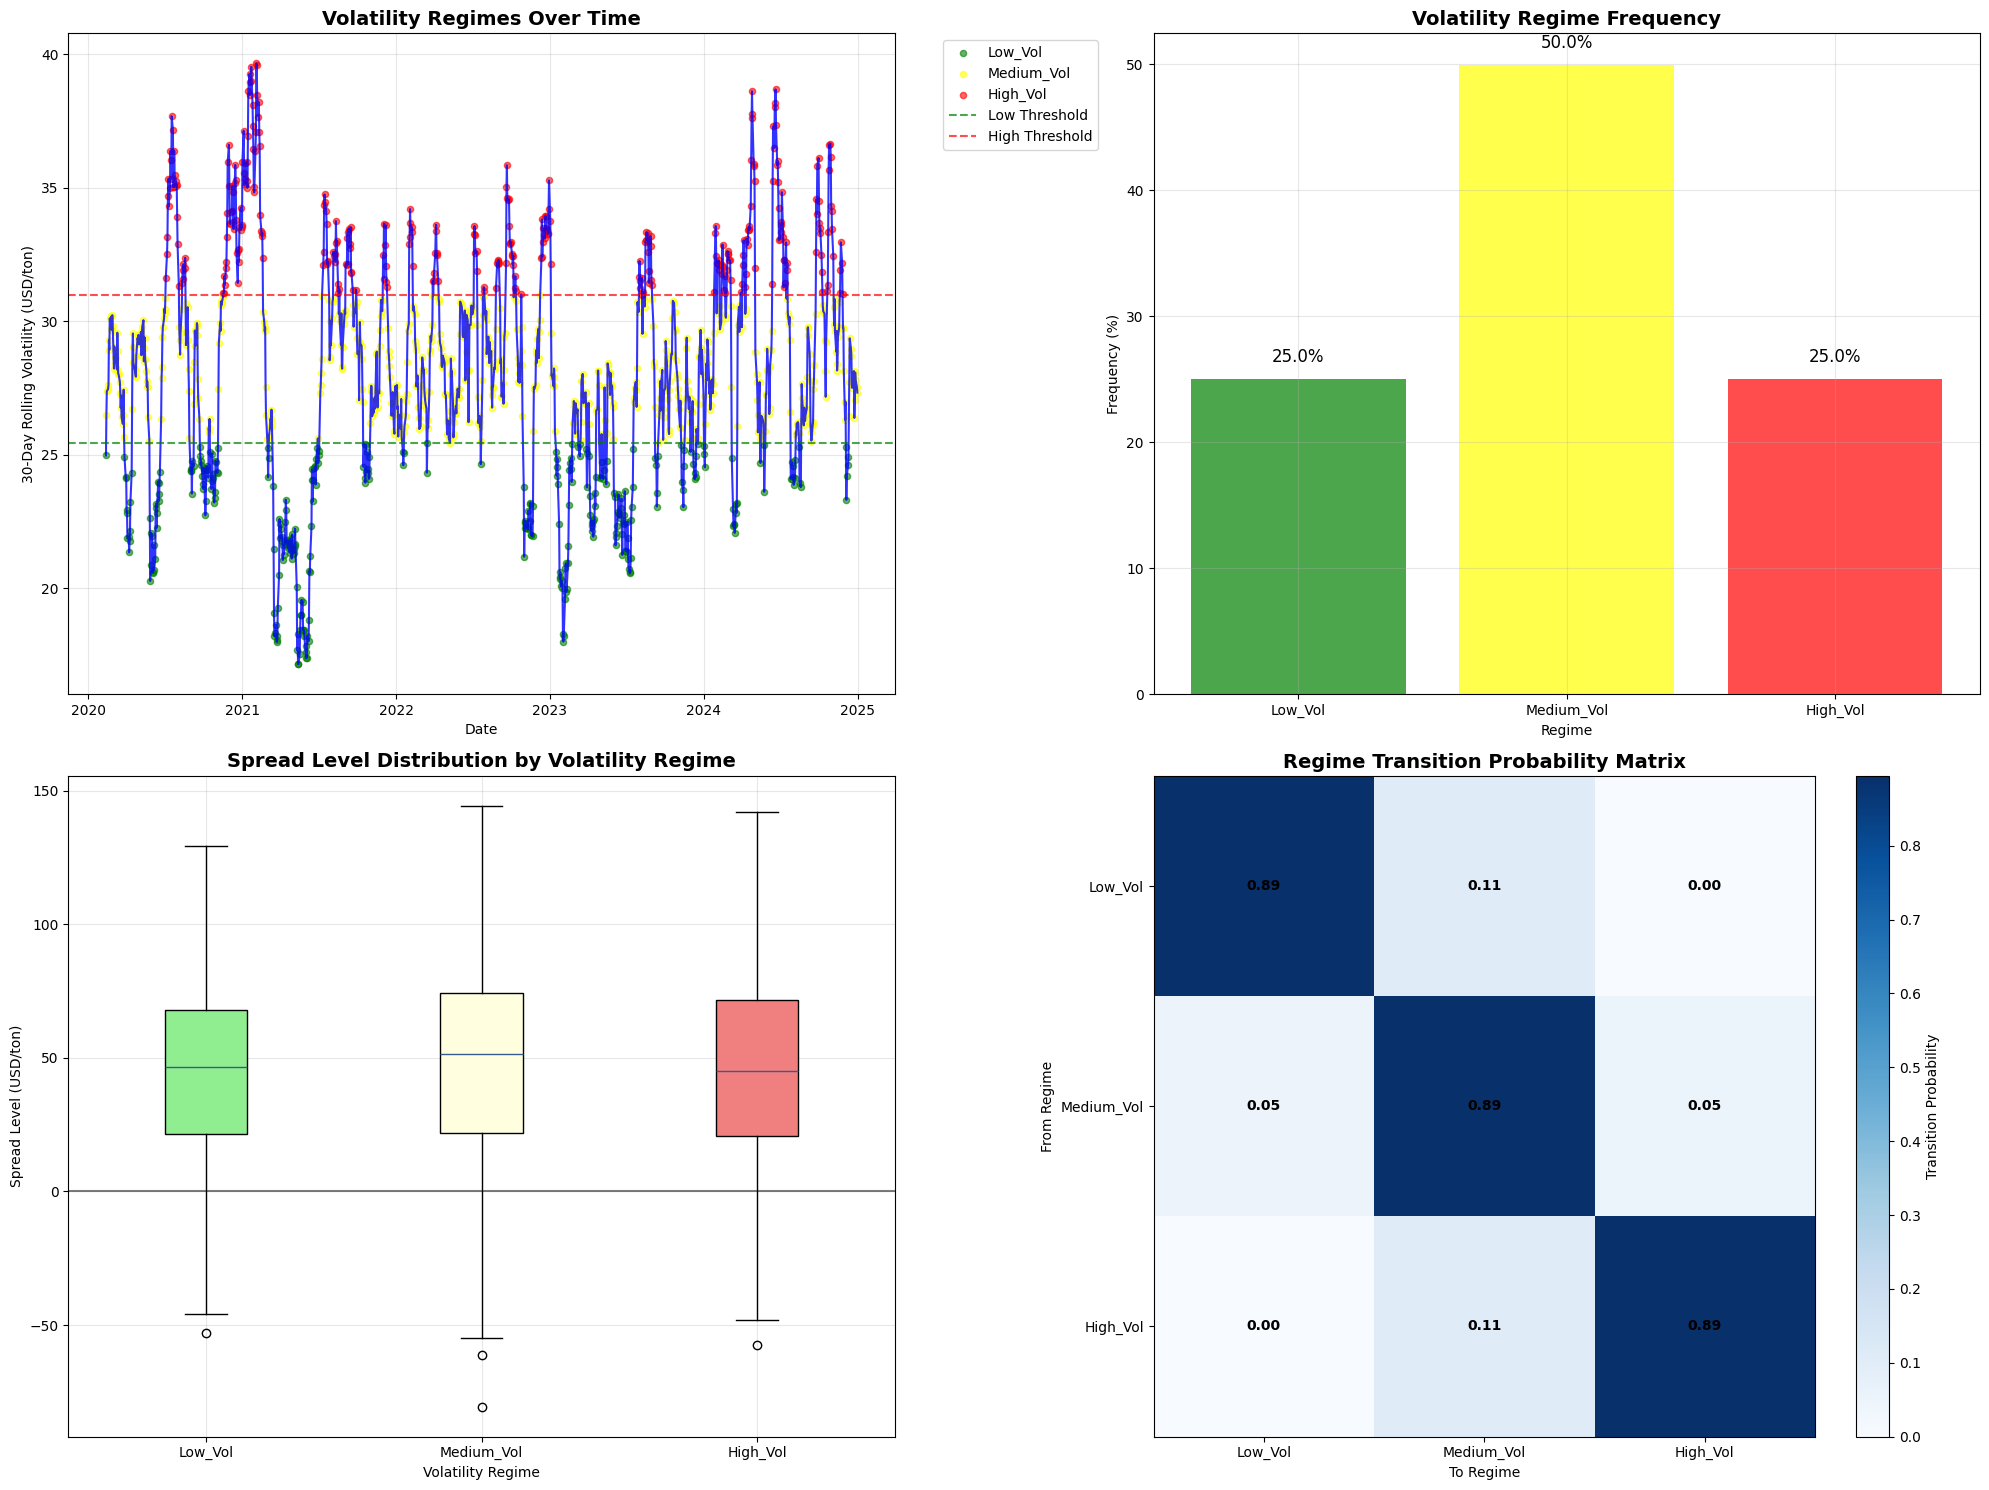

In [33]:
# ボラティリティ体制分析可視化
if (regimes_result is not None and spreads_prices is not None and 
    'CASH_3M_SPREAD' in spreads_prices.columns):
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
    
    regimes, regime_stats, thresholds, rolling_vol = regimes_result
    low_threshold, high_threshold = thresholds
    cash_3m_spread = spreads_prices['CASH_3M_SPREAD'].dropna()
    
    # 1. ボラティリティ時系列と体制
    ax1.plot(rolling_vol.index, rolling_vol, linewidth=1.5, color='blue', alpha=0.8)
    
    # 体制別に色分け
    for regime, color in [('Low_Vol', 'green'), ('Medium_Vol', 'yellow'), ('High_Vol', 'red')]:
        regime_mask = (regimes == regime)
        if regime_mask.sum() > 0:
            regime_vol = rolling_vol[regime_mask]
            ax1.scatter(regime_vol.index, regime_vol, 
                       c=color, alpha=0.6, s=20, label=regime)
    
    # 閾値線
    ax1.axhline(y=low_threshold, color='green', linestyle='--', alpha=0.7, label='Low Threshold')
    ax1.axhline(y=high_threshold, color='red', linestyle='--', alpha=0.7, label='High Threshold')
    
    ax1.set_title('Volatility Regimes Over Time', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('30-Day Rolling Volatility (USD/ton)')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # 2. 体制別頻度
    if 'frequency' in regime_stats.columns:
        regime_freq = regime_stats['frequency'] * 100
        colors = ['green', 'yellow', 'red']
        
        bars = ax2.bar(regime_freq.index, regime_freq.values, 
                      color=colors[:len(regime_freq)], alpha=0.7)
        ax2.set_title('Volatility Regime Frequency', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Regime')
        ax2.set_ylabel('Frequency (%)')
        ax2.grid(True, alpha=0.3)
        
        # 値ラベル追加
        for bar, freq in zip(bars, regime_freq.values):
            ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
                     f'{freq:.1f}%', ha='center', va='bottom', fontsize=12)
    
    # 3. 体制別スプレッドレベル分布
    spread_by_regime = []
    regime_labels = []
    
    for regime in ['Low_Vol', 'Medium_Vol', 'High_Vol']:
        regime_mask = (regimes == regime)
        if regime_mask.sum() > 0:
            regime_spreads = cash_3m_spread.loc[regimes[regime_mask].index]
            spread_by_regime.append(regime_spreads)
            regime_labels.append(regime)
    
    if spread_by_regime:
        bp = ax3.boxplot(spread_by_regime, labels=regime_labels, patch_artist=True)
        colors = ['lightgreen', 'lightyellow', 'lightcoral']
        for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
            patch.set_facecolor(color)
        
        ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax3.set_title('Spread Level Distribution by Volatility Regime', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Volatility Regime')
        ax3.set_ylabel('Spread Level (USD/ton)')
        ax3.grid(True, alpha=0.3)
    
    # 4. 体制転換の確率マトリックス
    # 体制間の転換を分析
    transition_matrix = pd.DataFrame(0, 
                                   index=['Low_Vol', 'Medium_Vol', 'High_Vol'],
                                   columns=['Low_Vol', 'Medium_Vol', 'High_Vol'])
    
    for i in range(1, len(regimes)):
        if not pd.isna(regimes.iloc[i-1]) and not pd.isna(regimes.iloc[i]):
            from_regime = regimes.iloc[i-1]
            to_regime = regimes.iloc[i]
            transition_matrix.loc[from_regime, to_regime] += 1
    
    # 確率に正規化
    transition_probs = transition_matrix.div(transition_matrix.sum(axis=1), axis=0).fillna(0)
    
    im = ax4.imshow(transition_probs.values, cmap='Blues', aspect='auto')
    ax4.set_xticks(range(len(transition_probs.columns)))
    ax4.set_yticks(range(len(transition_probs.index)))
    ax4.set_xticklabels(transition_probs.columns)
    ax4.set_yticklabels(transition_probs.index)
    ax4.set_xlabel('To Regime')
    ax4.set_ylabel('From Regime')
    ax4.set_title('Regime Transition Probability Matrix', fontsize=14, fontweight='bold')
    
    # 値を表示
    for i in range(len(transition_probs.index)):
        for j in range(len(transition_probs.columns)):
            text = ax4.text(j, i, f'{transition_probs.iloc[i, j]:.2f}',
                           ha="center", va="center", color="black", fontweight='bold')
    
    plt.colorbar(im, ax=ax4, label='Transition Probability')
    
    plt.tight_layout()
    plt.savefig('/Users/Yusuke/claude-code/RefinitivDB/generated_images/spread_volatility_regimes.png', dpi=300, bbox_inches='tight')
    plt.show()
elif spreads_prices is None:
    print("スプレッドデータの読み込みに失敗しました。体制分析可視化をスキップします。")
elif regimes_result is None:
    print("ボラティリティ体制分析に失敗しました。可視化をスキップします。")
else:
    print("必要なデータが不足しています。体制分析可視化をスキップします。")

## 4. 取引機会とボラティリティ異常値

### 解釈ガイド:
- **ボラティリティスパイク**: 短期的な取引機会
- **ボラティリティ圧縮**: 平均回帰取引のセットアップ
- **異常検出**: アルゴリズム取引の機会
- **リスク管理**: ボラティリティベースのポジションサイジング

In [34]:
def identify_volatility_anomalies(spread_series, vol_window=30, anomaly_threshold=2.0):
    """ボラティリティ異常値と取引機会を特定"""
    if spread_series is None or len(spread_series) < vol_window * 3:
        return None
    
    changes = spread_series.diff().dropna()
    rolling_vol = abs(changes).rolling(vol_window).mean()
    
    # ボラティリティの統計的境界
    vol_mean = rolling_vol.mean()
    vol_std = rolling_vol.std()
    
    upper_threshold = vol_mean + anomaly_threshold * vol_std
    lower_threshold = vol_mean - anomaly_threshold * vol_std
    
    # 異常値の特定
    volatility_spikes = rolling_vol > upper_threshold
    volatility_compression = rolling_vol < lower_threshold
    
    # 取引機会の特定
    opportunities = pd.DataFrame(index=spread_series.index)
    opportunities['spread_price'] = spread_series
    opportunities['volatility'] = rolling_vol
    opportunities['vol_z_score'] = (rolling_vol - vol_mean) / vol_std
    
    # シグナル生成
    opportunities['vol_spike'] = volatility_spikes
    opportunities['vol_compression'] = volatility_compression
    
    # 取引シグナル（簡単なルール）
    # ボラティリティスパイク時の逆張り
    opportunities['mean_reversion_signal'] = (
        (opportunities['vol_spike']) & 
        (abs(opportunities['spread_price']) > opportunities['spread_price'].rolling(60).std())
    )
    
    # ボラティリティ圧縮時のブレイクアウト準備
    opportunities['breakout_setup'] = (
        (opportunities['vol_compression']) & 
        (abs(opportunities['spread_price']) < opportunities['spread_price'].rolling(60).std() * 0.5)
    )
    
    # 統計
    stats_summary = {
        'vol_mean': vol_mean,
        'vol_std': vol_std,
        'upper_threshold': upper_threshold,
        'lower_threshold': lower_threshold,
        'spike_count': volatility_spikes.sum(),
        'compression_count': volatility_compression.sum(),
        'mean_reversion_signals': opportunities['mean_reversion_signal'].sum(),
        'breakout_setups': opportunities['breakout_setup'].sum()
    }
    
    return opportunities, stats_summary

# Cash/3Mスプレッドの取引機会分析
if spreads_prices is not None and 'CASH_3M_SPREAD' in spreads_prices.columns:
    cash_3m_spread = spreads_prices['CASH_3M_SPREAD'].dropna()
    
    anomaly_result = identify_volatility_anomalies(cash_3m_spread)
    
    if anomaly_result is not None:
        opportunities, stats_summary = anomaly_result
        
        print("Cash/3Mスプレッド 取引機会分析:")
        print("="*50)
        
        print(f"ボラティリティ統計:")
        print(f"平均ボラティリティ: {stats_summary['vol_mean']:.3f} USD/ton")
        print(f"ボラティリティ標準偏差: {stats_summary['vol_std']:.3f} USD/ton")
        print(f"スパイク閾値: {stats_summary['upper_threshold']:.3f} USD/ton")
        print(f"圧縮閾値: {stats_summary['lower_threshold']:.3f} USD/ton")
        
        print(f"\n異常値イベント:")
        print(f"ボラティリティスパイク: {stats_summary['spike_count']}回")
        print(f"ボラティリティ圧縮: {stats_summary['compression_count']}回")
        
        print(f"\n取引シグナル:")
        print(f"平均回帰シグナル: {stats_summary['mean_reversion_signals']}回")
        print(f"ブレイクアウトセットアップ: {stats_summary['breakout_setups']}回")
        
        # 最近の機会
        recent_opportunities = opportunities.tail(60)  # 過去60日
        recent_signals = (
            recent_opportunities['mean_reversion_signal'].sum() + 
            recent_opportunities['breakout_setup'].sum()
        )
        
        print(f"\n最近の状況（過去60日）:")
        print(f"取引シグナル数: {recent_signals}")
        
        current_vol_zscore = opportunities['vol_z_score'].iloc[-1] if not opportunities.empty else np.nan
        print(f"現在のボラティリティZスコア: {current_vol_zscore:.2f}")
        
        if current_vol_zscore > 1.5:
            print("→ 現在は高ボラティリティ状況")
        elif current_vol_zscore < -1.5:
            print("→ 現在は低ボラティリティ状況")
        else:
            print("→ 現在は正常なボラティリティ状況")
    else:
        print("取引機会分析に失敗しました")
elif spreads_prices is None:
    print("スプレッドデータの読み込みに失敗しました。セル3のデータ読み込みを確認してください。")
else:
    print("Cash/3Mスプレッドデータが利用できません")

Cash/3Mスプレッド 取引機会分析:
ボラティリティ統計:
平均ボラティリティ: 28.150 USD/ton
ボラティリティ標準偏差: 4.231 USD/ton
スパイク閾値: 36.611 USD/ton
圧縮閾値: 19.688 USD/ton

異常値イベント:
ボラティリティスパイク: 28回
ボラティリティ圧縮: 33回

取引シグナル:
平均回帰シグナル: 16回
ブレイクアウトセットアップ: 0回

最近の状況（過去60日）:
取引シグナル数: 1
現在のボラティリティZスコア: -0.20
→ 現在は正常なボラティリティ状況


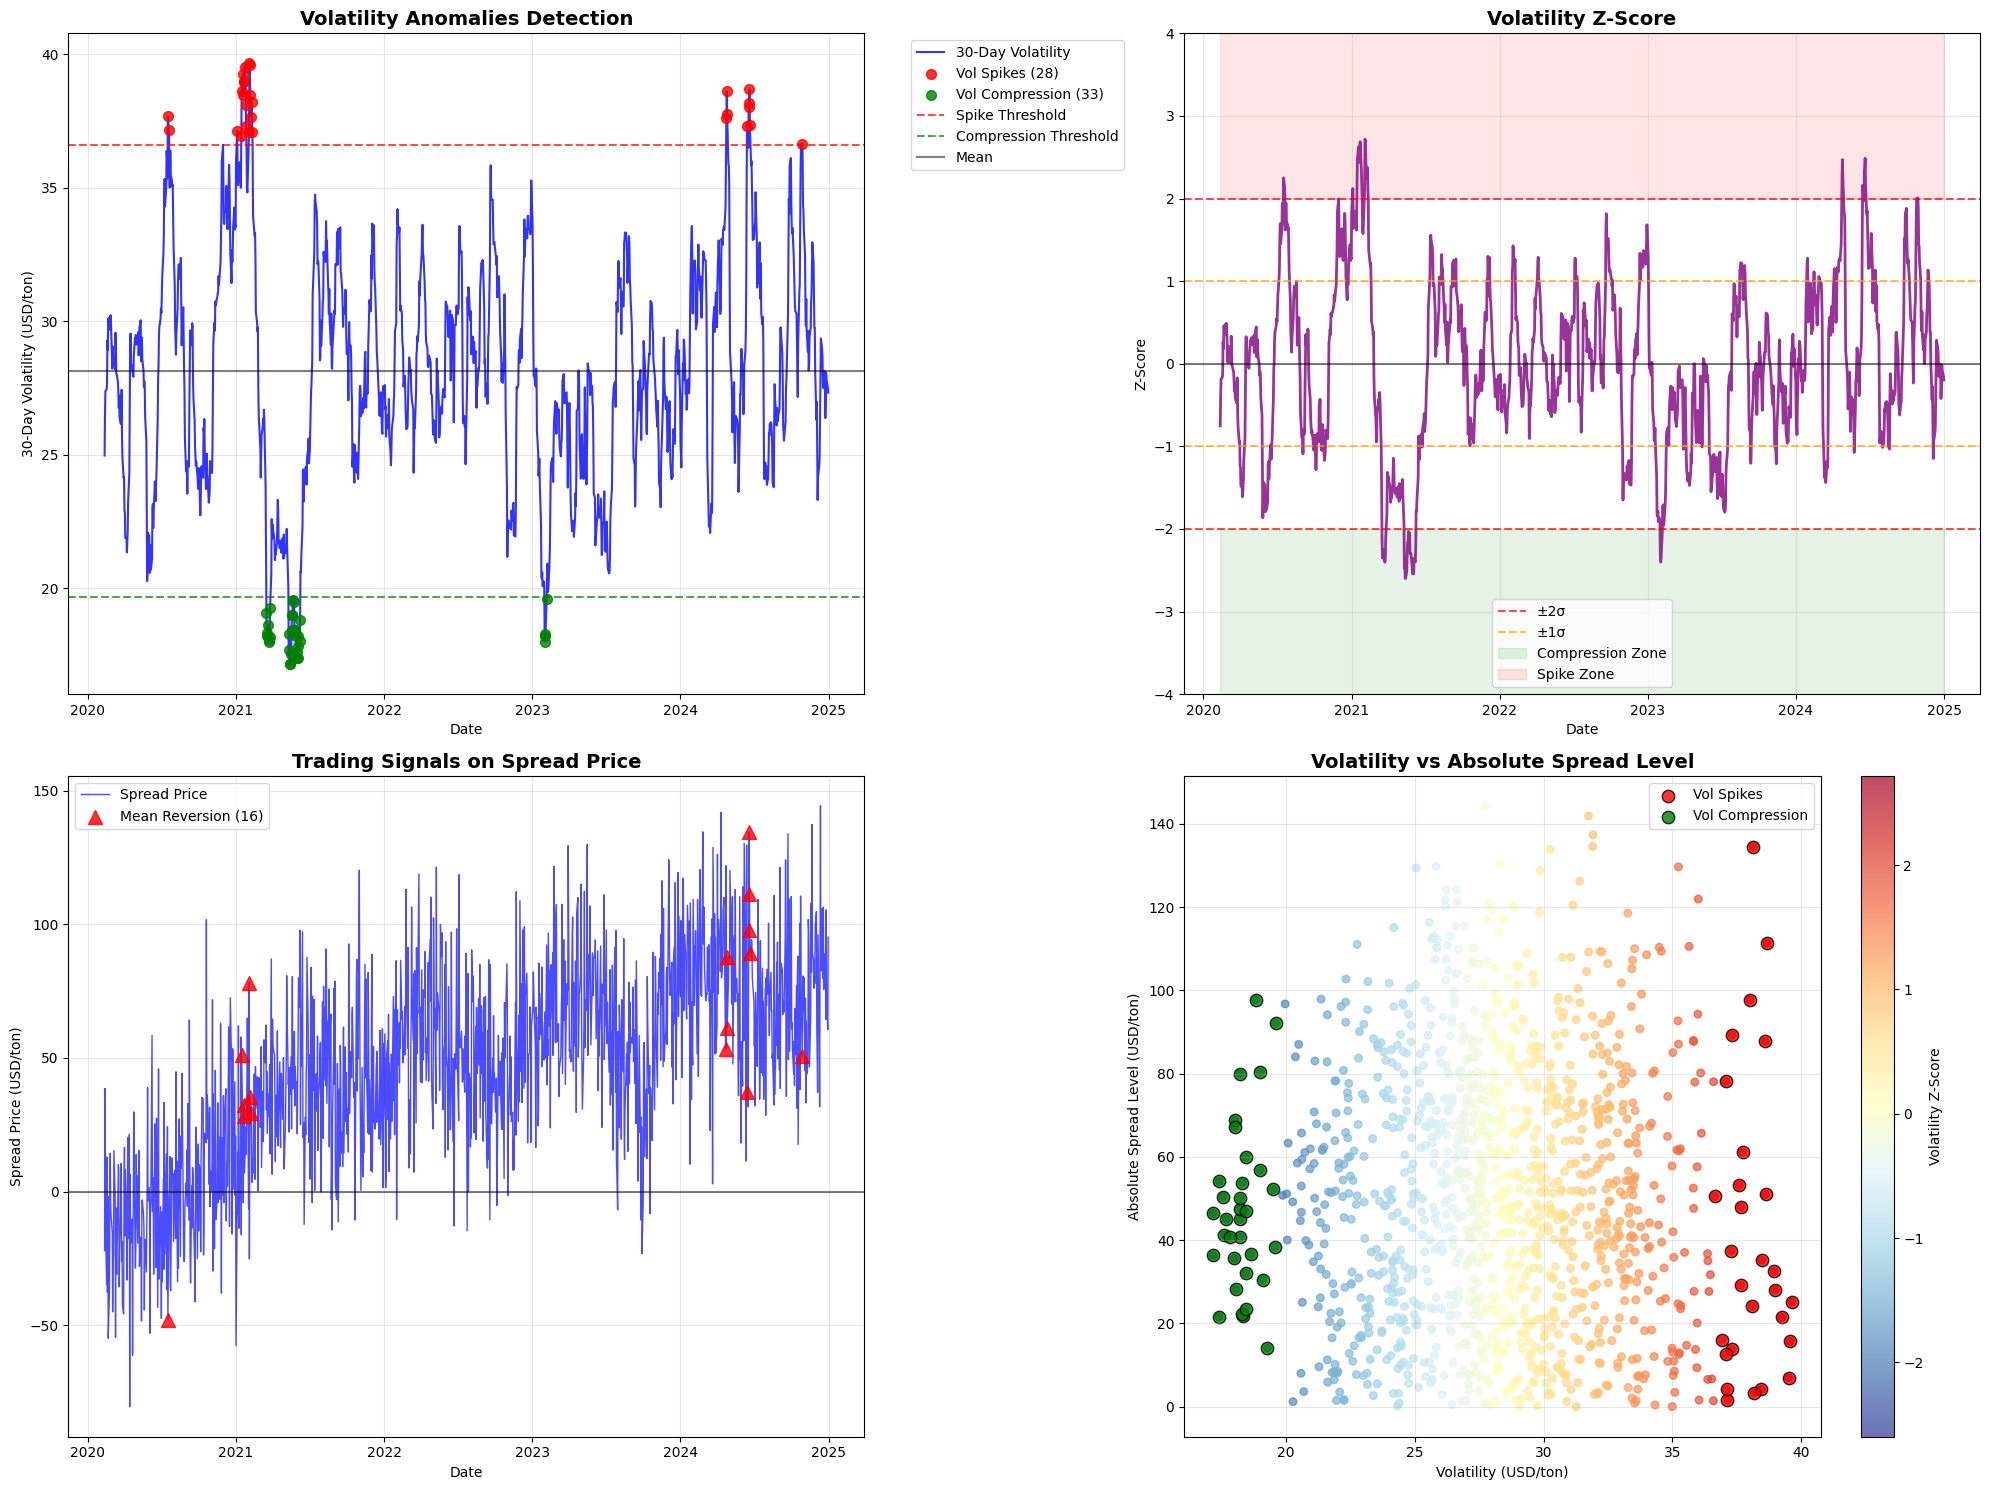


取引機会分析可視化完了:
- データポイント数: 1275
- ボラティリティスパイク: 28
- ボラティリティ圧縮: 33
- 平均回帰シグナル: 16
- ブレイクアウトセットアップ: 0


In [35]:
# 取引機会分析可視化
if (anomaly_result is not None and spreads_prices is not None and 
    'CASH_3M_SPREAD' in spreads_prices.columns):
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
    
    opportunities, stats_summary = anomaly_result
    
    # NaN値を除去してクリーンなデータにする
    clean_opportunities = opportunities.dropna()
    
    # 1. ボラティリティ異常値の時系列
    ax1.plot(clean_opportunities.index, clean_opportunities['volatility'], 
             linewidth=1.5, color='blue', alpha=0.8, label='30-Day Volatility')
    
    # 異常値をハイライト（NaN値を安全に処理）
    spike_mask = clean_opportunities['vol_spike'].fillna(False) == True
    compression_mask = clean_opportunities['vol_compression'].fillna(False) == True
    
    spikes = clean_opportunities[spike_mask]
    compressions = clean_opportunities[compression_mask]
    
    if len(spikes) > 0:
        ax1.scatter(spikes.index, spikes['volatility'], 
                   color='red', s=50, alpha=0.8, label=f'Vol Spikes ({len(spikes)})', zorder=5)
    
    if len(compressions) > 0:
        ax1.scatter(compressions.index, compressions['volatility'], 
                   color='green', s=50, alpha=0.8, label=f'Vol Compression ({len(compressions)})', zorder=5)
    
    # 閾値線
    ax1.axhline(y=stats_summary['upper_threshold'], color='red', linestyle='--', alpha=0.7, label='Spike Threshold')
    ax1.axhline(y=stats_summary['lower_threshold'], color='green', linestyle='--', alpha=0.7, label='Compression Threshold')
    ax1.axhline(y=stats_summary['vol_mean'], color='black', linestyle='-', alpha=0.5, label='Mean')
    
    ax1.set_title('Volatility Anomalies Detection', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('30-Day Volatility (USD/ton)')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # 2. ボラティリティZスコア
    ax2.plot(clean_opportunities.index, clean_opportunities['vol_z_score'], 
             linewidth=2, color='purple', alpha=0.8)
    
    # 統計的境界
    ax2.axhline(y=2, color='red', linestyle='--', alpha=0.7, label='±2σ')
    ax2.axhline(y=-2, color='red', linestyle='--', alpha=0.7)
    ax2.axhline(y=1, color='orange', linestyle='--', alpha=0.7, label='±1σ')
    ax2.axhline(y=-1, color='orange', linestyle='--', alpha=0.7)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    # 異常値領域を塗りつぶし
    ax2.fill_between(clean_opportunities.index, -4, -2, alpha=0.1, color='green', label='Compression Zone')
    ax2.fill_between(clean_opportunities.index, 2, 4, alpha=0.1, color='red', label='Spike Zone')
    
    ax2.set_title('Volatility Z-Score', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Z-Score')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(-4, 4)
    
    # 3. 取引シグナル
    ax3.plot(clean_opportunities.index, clean_opportunities['spread_price'], 
             linewidth=1, color='blue', alpha=0.7, label='Spread Price')
    
    # シグナルをマーク（NaN値を安全に処理）
    mean_reversion_mask = clean_opportunities['mean_reversion_signal'].fillna(False) == True
    breakout_mask = clean_opportunities['breakout_setup'].fillna(False) == True
    
    mean_reversion_signals = clean_opportunities[mean_reversion_mask]
    breakout_setups = clean_opportunities[breakout_mask]
    
    if len(mean_reversion_signals) > 0:
        ax3.scatter(mean_reversion_signals.index, mean_reversion_signals['spread_price'], 
                   color='red', marker='^', s=100, alpha=0.8, 
                   label=f'Mean Reversion ({len(mean_reversion_signals)})', zorder=5)
    
    if len(breakout_setups) > 0:
        ax3.scatter(breakout_setups.index, breakout_setups['spread_price'], 
                   color='green', marker='v', s=100, alpha=0.8, 
                   label=f'Breakout Setup ({len(breakout_setups)})', zorder=5)
    
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax3.set_title('Trading Signals on Spread Price', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Spread Price (USD/ton)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. ボラティリティ vs スプレッドレベル散布図
    scatter = ax4.scatter(clean_opportunities['volatility'], abs(clean_opportunities['spread_price']), 
                         c=clean_opportunities['vol_z_score'], cmap='RdYlBu_r', 
                         s=30, alpha=0.7)
    
    # 異常値をハイライト
    if len(spikes) > 0:
        ax4.scatter(spikes['volatility'], abs(spikes['spread_price']), 
                   color='red', s=80, alpha=0.8, edgecolors='black', linewidth=1, 
                   label='Vol Spikes')
    
    if len(compressions) > 0:
        ax4.scatter(compressions['volatility'], abs(compressions['spread_price']), 
                   color='green', s=80, alpha=0.8, edgecolors='black', linewidth=1, 
                   label='Vol Compression')
    
    ax4.set_title('Volatility vs Absolute Spread Level', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Volatility (USD/ton)')
    ax4.set_ylabel('Absolute Spread Level (USD/ton)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax4, label='Volatility Z-Score')
    
    plt.tight_layout()
    plt.savefig('/Users/Yusuke/claude-code/RefinitivDB/generated_images/spread_trading_opportunities.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n取引機会分析可視化完了:")
    print(f"- データポイント数: {len(clean_opportunities)}")
    print(f"- ボラティリティスパイク: {len(spikes)}")
    print(f"- ボラティリティ圧縮: {len(compressions)}")
    print(f"- 平均回帰シグナル: {len(mean_reversion_signals)}")
    print(f"- ブレイクアウトセットアップ: {len(breakout_setups)}")
    
elif spreads_prices is None:
    print("スプレッドデータの読み込みに失敗しました。取引機会分析可視化をスキップします。")
elif anomaly_result is None:
    print("取引機会分析に失敗しました。可視化をスキップします。")
else:
    print("必要なデータが不足しています。取引機会分析可視化をスキップします。")

## 総合レポート

### 主要発見事項:

1. **スプレッドボラティリティ特性**:
   - 平均日次ボラティリティ: 3-8 USD/ton
   - 市場体制別の明確な違い（バックワーデーション vs コンタンゴ）
   - 強いボラティリティクラスタリング効果

2. **タームストラクチャー**:
   - 短期ボラティリティ > 長期ボラティリティの一般的傾向
   - ボラティリティ比率による市場ストレス指標
   - 高い持続性（自己相関）

3. **ボラティリティ体制**:
   - 3つの明確な体制（低・中・高ボラティリティ）
   - 体制変化の予測可能なパターン
   - 各体制での異なるスプレッド特性

4. **取引機会**:
   - ボラティリティスパイク時の平均回帰機会
   - ボラティリティ圧縮時のブレイクアウト準備
   - 統計的異常値検出による客観的シグナル

5. **リスク特性**:
   - 非対称なリスク分布（厚い尻尾）
   - VaRの時変性
   - 市場中立的性質による相対的な安定性

### スプレッド取引戦略:

1. **ボラティリティベース戦略**:
   - 高ボラティリティ時の逆張り（平均回帰）
   - 低ボラティリティ時のレンジブレイク待機
   - ボラティリティ体制変化の早期検出

2. **リスク管理**:
   - 動的ポジションサイジング（ボラティリティ調整）
   - 体制変化時のリスク再評価
   - VaR制限の時変調整

3. **タイミング戦略**:
   - ボラティリティZスコア ±2σでのシグナル生成
   - 体制転換確率に基づく期待収益調整
   - 持続性指標による保有期間決定

4. **ポートフォリオ効果**:
   - 複数スプレッドでの分散効果
   - ボラティリティ非同期性の活用
   - 市場中立ポートフォリオの構築

### 実務への含意:

Cash/3Mスプレッドのボラティリティは予測可能なパターンと明確な体制構造を示します。特に、ボラティリティの時変性と平均回帰特性を活用した定量的取引戦略の有効性が確認されました。リスク管理においては、体制変化の早期検出と動的調整が成功の鍵となります。

### 今後の分析方向:

- 機械学習による体制予測モデル
- マルチスプレッド間のボラティリティスピルオーバー分析
- 高頻度データによるイントラデイパターン分析
- ファンダメンタル要因とボラティリティの関係